# Diffusion Models for particle physics



[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/florpi/summer_school_generative/blob/main/3_diffusion_models.ipynb)

Code that needs to be filled in will be marked by #TODOs. There will also be some questions to check your understanding within the notebook marked with 🤔 

In [ ]:
# We'll start by installing some packages while you read the text below.
!pip install numpy jax numpyro flax einops optax matplotlib scikit-learn diffrax jetnet

Diffusion models are particularly interesting due to their flexibility to adapt not only to images but also to diverse data types like point cloud data. In this tutorial we will highlight this flexibility by showing an application of diffusion to jet point cloud data.

Jets in particle physics refer to the high-energy streams of particles that result from the fragmentation and hadronization of quarks and gluons. These phenomena are common in collisions at high-energy particle accelerators, such as the Large Hadron Collider (LHC) at CERN. The study of jets offers profound insights into quantum chromodynamics (QCD), the branch of physics governing the behavior of the fundamental constituents of matter.

In the LHC, vast datasets of collision simulations are created using Monte Carlo (MC) methods, translating theoretical concepts into observable patterns for real-world physics analyses. This process is computationally intensive, but generative models hold the potential to accelerate simulators by orders of magnitude.

Other reasons why you should care about jets:


<img src="./images/screenshot.png" alt="drawing" width="400"/>


In [ ]:
from functools import partial
import jax
import jax.numpy as np
import flax.linen as nn
import optax
import diffrax as dfx
from sklearn import datasets, preprocessing
import matplotlib.pyplot as plt
from typing import Dict
from tqdm import trange
from jetnet.datasets import JetNet, TopTagging



[JetNet](https://github.com/jet-net/jetnet) consists of simulated jets with transverse momenta $p_T ≈ 1 \mathrm{TeV}$, originating from gluons, top quarks, and light quarks produced in $13 \mathrm{TeV}$ proton-proton collisions in a simplified detector. Jets are limited to a maximum of $30$ particles (selecting the highest $p_T$ particles). Jets with fewer than $30$ particles are zero-padded up to $30$; in addition there is an extra mask feature in the dataset which is set to 1 if the particle is real and 0 if the particle has been zero-padded. The other three particles features are the relative angular coordinates $\eta^\mathrm{rel} = \eta^\mathrm{particle} - \eta^\mathrm{jet}$  and $\phi^\mathrm{rel} = \phi^\mathrm{particle} - \phi^\mathrm{jet}$, and the relative transverse momentum $p_T^\mathrm{rel} = p_T^\mathrm{particle} - p_T^\mathrm{jet}$,

In [ ]:
jet_type=["g", "q", "t"]
n_particles = 30
n_features = 3 # keep the first 3 features (eta_rel, phi_rel, pt_rel)
particle_data, jet_data = JetNet.getData(
    jet_type=jet_type, data_dir="./data/", num_particles=n_particles
)


In [2]:
# keep only jets that have at least the required number of particles
mask_particles = particle_data[...,-1].sum(axis=-1) == n_particles
particle_data = particle_data[mask_particles]
particle_data = particle_data[...,:n_features]

Text(0.5, 0.98, 'Simulated Jets')

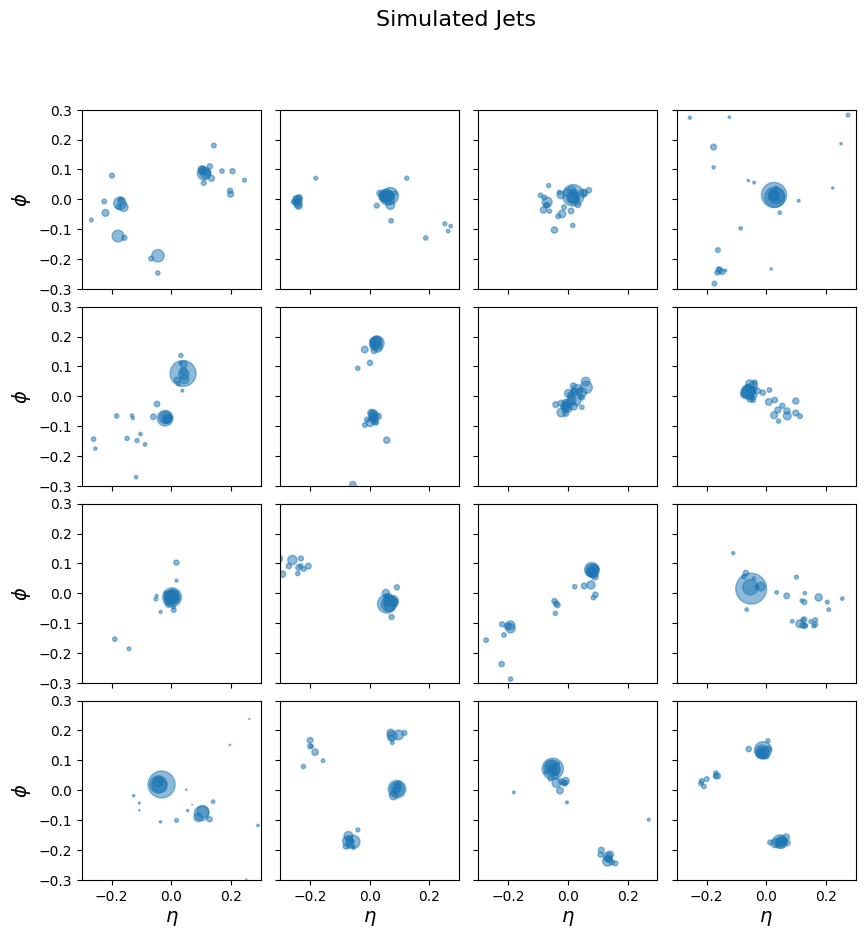

In [3]:
# Let's have a look at how those jets look like, we will plot their angular coordinates and represent 
# their transverse momenta with the size of the marker
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec


fig = plt.figure(figsize=(10, 10))
gs = GridSpec(4, 4,wspace=0.1, hspace=0.1)

first_ax = None

for i in range(16):
    if i ==0:
        ax = fig.add_subplot(gs[i])
        first_ax = ax
    else:
        ax = fig.add_subplot(gs[i], sharex=first_ax, sharey=first_ax)
        
    
    ax.scatter(*particle_data[i, :, :2].T, s=1000 * (particle_data[i, :, 2]), alpha=0.5)
    ax.set_aspect('equal', adjustable='box')

    
    ax.set_xlim(-0.3, 0.3)
    ax.set_ylim(-0.3, 0.3)
    if i % 4 == 0:
        ax.set_ylabel(r"$\phi$", fontsize=14)
    if i // 4 == 3:
        ax.set_xlabel(r"$\eta$", fontsize=14)
    if i // 4 < 3: # Hide x-tick labels for the first three rows
        plt.setp(ax.get_xticklabels(), visible=False)
    if i % 4 != 0: # Hide y-tick labels for all but the first column
        plt.setp(ax.get_yticklabels(), visible=False)

    # Remove top and right spines
    # Add minor grid lines
    ax.grid(True, which='minor', linestyle=':', linewidth='0.5')


plt.suptitle("Simulated Jets", fontsize=16)

Let's look at the histogram of the particle data for 100 jets, we will try to reproduce these histograms with our generated samples

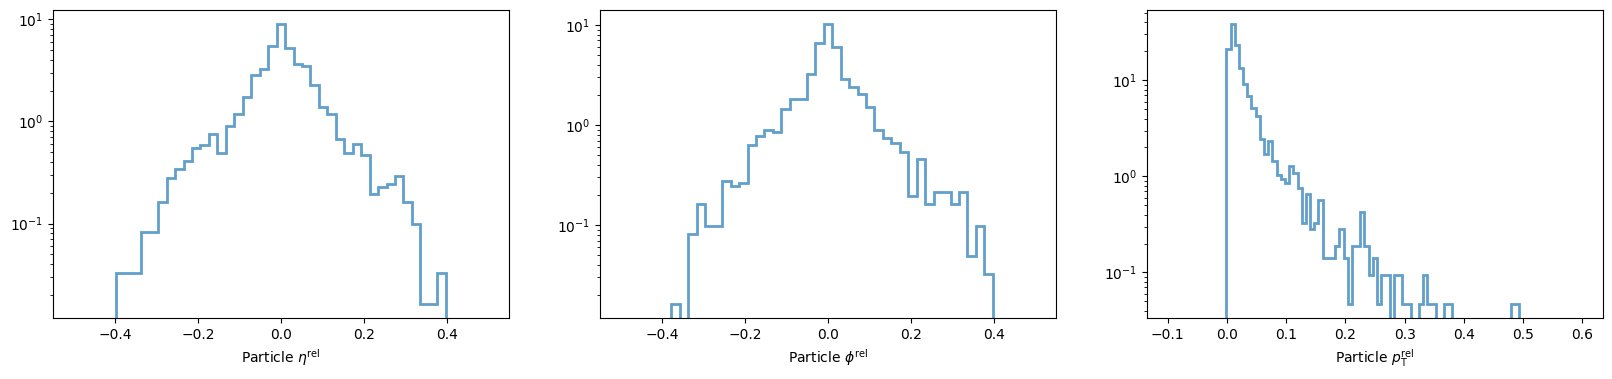

In [4]:
fig, ax = plt.subplots(ncols=3, figsize=(20, 4), sharex=False, sharey=False)

concat_particle_data = np.concatenate(particle_data[:100])

eta_bins= np.linspace(-0.5, 0.5, 50)
ax[0].hist(concat_particle_data[:,0], histtype='step', density=True, bins=eta_bins, lw=2, alpha=0.7, label='Sim',)
ax[0].set_xlabel(r"Particle $\eta^\mathrm{rel}$")
ax[0].set_yscale('log')

ax[1].hist(concat_particle_data[:,1], histtype='step', density=True, bins=eta_bins, lw=2, alpha=0.7, label='Sim',)
ax[1].set_xlabel(r"Particle $\phi^\mathrm{rel}$")
ax[1].set_yscale('log')


pt_bins= np.linspace(-0.1, 0.6, 100)
ax[2].hist(concat_particle_data[:,2], histtype='step', density=True, bins=pt_bins, lw=2, alpha=0.7, label='Sim',)
ax[2].set_xlabel(r"Particle $p_\mathrm{T}^\mathrm{rel}$")

ax[2].set_yscale('log')



In [5]:
# Don't forget to standarize the features

mean_per_feature = particle_data.mean(axis=(0,1))
std_per_feature = particle_data.std(axis=(0,1))

normed_particle_data = (particle_data - mean_per_feature) / std_per_feature

## Forward diffusion

See the [DDPM paper](https://arxiv.org/abs/2006.11239)for a comprehensive description of the diffusion model implemented here.

Let's first look at the forward diffusion model, in this case we are going to progressively add noise to our data by sampling

$q(z_t|z_{t-1}) = \mathcal{N}(z_t;\sqrt{\alpha_t} z_{t-1}, \beta_t)$

where the signal to noise ratio $SNR(t) = \alpha_t / \beta_t^2$ is strictly monotonically decreasing as a function of diffusion time $t$. This formalizes the notion that the $z_t$ is increasingly noisy as we go forward in time. The way in which $\beta$ depends on t defines the so-called *variance schedule*. 

A specific diffusion model, known as *variance-preserving* can be defined by setting $\alpha_t = 1 - \beta_t$

Notably, we can sample $x_t$ at any arbitrary time step $t$ in closed form from $x_0$

$q(x_t|x_0) = \mathcal{N}(x_t;\sqrt{\bar{\alpha}_t}x_0, 1 - \bar{\alpha}_t)$

where $ \bar{\alpha}_t = \prod_{s=1}^t \alpha_s$ 

Let's write some code to sample noised data at different time steps

In [6]:
def beta_t(t: np.array, min_variance: float =1e-4, max_variance: float =0.02)->np.array:
    """ Variance of q(x_{t-1} | x_t) as a function of t, it defines the amount of noise to add at time t.
    In this case, we implement a simple linear variance schedule.

    Args:
        t (np.array): diffusion time t. 
        min_variance (float, optional): minimum variance added. Defaults to 1e-4.
        max_variance (float, optional): maximum variance added. Defaults to 0.02.

    Returns:
        np.array: beta values 
    """
    return #TODO: implement the linear variance schedule

def alpha_t(t: np.array, min_variance: float =1e-4, max_variance: float =0.02)->np.array:
    """ Multiplicative factor that reduces the signal in the data as a function of t.
    Here we implement a variance-preserving schedule, i.e. alpha_t = 1 - beta_t

    Args:
        t (np.array): diffusion time t. 
        min_variance (float, optional): minimum variance added. Defaults to 1e-4.
        max_variance (float, optional): maximum variance added. Defaults to 0.02.

    Returns:
        np.array: alpha values
    """
    return #TODO: implement the variance-preserving schedule, as a function of beta_t

def alpha_t_bar(t_n: int, t_N: int =100, min_variance: float =1e-4, max_variance: float =0.02)->float:
    """ Cumulative product of alpha_t from t=0 to t=t_n

    Args:
        t_n (int): upper limit of the cumulative product 
        t_N (int, optional): total number of time steps. Defaults to 100.
        min_variance (float, optional): minimum variance added. Defaults to 1e-4.
        max_variance (float, optional): maximum variance added. Defaults to 0.02.

    Returns:
        float: alpha_t bar value 
    """
    return #TODO: implement the cumulative product of alpha_t from t=0 to t=t_n


def forward_diffusion(x: np.array, t_n: np.array, t_N: int, key: np.array)->np.array:
    """ Forward diffusion step, i.e. x_t = alpha_t * x_{t-1} + sqrt(1 - alpha_t) * eps_t evalated
    at different time steps t_n

    Args:
        x (np.array): original data (of shape ) 
        t_n (np.array): time steps to evaluate the diffusion at
        t_N (int): total number of time steps 
        key (np.array): jax random key 

    Returns:
        np.array: diffused data 
    """
    # sample some random noise
    eps = jax.random.normal(key, shape=x.shape)
    alpha_t_bar_array = jax.vmap(alpha_t_bar, in_axes=(0,None,None,None))(t_n, t_N, 1e-4, 0.02)
    return #TODO: implement the forward diffusion step described above


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/matplotlib/collections.py:963: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


Text(0.5, 0, 'Prior')

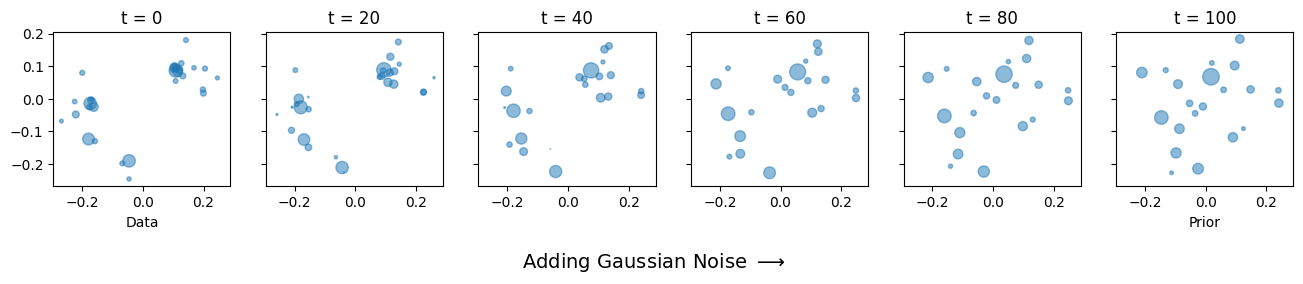

In [7]:
# Now we'll visualize the diffusion process, you should end up with coordinates and momenta 
# sampled from a Gaussian distribution with mean 0 and variance 1, at time t=100

times = np.arange(0,101, 20)
key = jax.random.PRNGKey(0)
t_N = 100

# let's run the forward diffusion on the first jet
noisy_samples = forward_diffusion(normed_particle_data[0], times, t_N, key)

fig, ax = plt.subplots(ncols=len(times),figsize=(16,2), sharex=True, sharey=True)

for i, time in enumerate(times):
    # let's undo the normalization to plot the data
    noisy_particles = noisy_samples[:,  :, i] * std_per_feature + mean_per_feature 
    ax[i].scatter(*noisy_particles[:,:2].T, s=1000 * noisy_particles[:,2], alpha=0.5)
    ax[i].set_title(f't = {time}')

plt.figtext(0.5, -0.3, 'Adding Gaussian Noise ' + r'$\longrightarrow$', ha='center', fontsize=14)
ax[0].set_xlabel('Data')
ax[-1].set_xlabel('Prior')


## Denoising the diffusion process
Now let's train a neural network that learns to denoise the noisy data during the diffusion process.

The denoising objective is given by 

$L(x) = \langle w(t) || \epsilon - \hat{\epsilon}_\theta(x_t,t)|| \rangle $

where $\epsilon$ is the true amount of noise added, and $\hat{\epsilon}_\theta(x_t,t)$ the noise predicted by neural network. Depending on the weight factor we chose, $w(t)$, the training objective will either be maximum likelihood, or maximum likelihood of noisy data with different noise levels. For now, we will implement a simple diffusion model with weight factor equal to 1.

In this example we will implement a simple multilayer perceptron to predict the amount added


🤔 After running the model with a trivial weight factor, how would you train the model to maximize the likelihood? i.e. what weight factor do you need to include?

🤔 After running the model with the MLP, can you improve the generated samples by training a graph neural network instead?

In [8]:
# let's flatten the particle data to work with an MLP
flattened_particle_data = normed_particle_data.reshape(len(normed_particle_data), -1)

class MLP(nn.Module):
    """ A simple MLP in Flax. This is the noise-prediction network.
    """
    hidden_dim: int = 32
    out_dim: int = 2
    n_layers: int = 2

    @nn.compact
    def __call__(self, x):
        for _ in range(self.n_layers):
            x = nn.Dense(features=self.hidden_dim)(x)
            x = nn.gelu(x)
        x = nn.Dense(features=self.out_dim)(x)
        return x

noise_prediction_nn = MLP(hidden_dim=1024, out_dim=n_particles*n_features, n_layers=5)

# the noise prediction neural network will take as input an array of features per particle,
# of shape (n_particles*n_features,) and the diffusion time t, and return the predicted noise
# at that time step

# Let's initialize the network with some random data, of size 10
t_n = np.arange(10)[:, None]
params = noise_prediction_nn.init(key, np.concatenate([flattened_particle_data[:10], t_n / t_N], axis=-1))


In [9]:
# Now let's define the loss function

def weight(t):
    return 1.


@partial(jax.jit, static_argnums=(3,))
def loss_fn(params: Dict, x: np.array, t_n: np.array, noise_prediction_nn: "nn.Module", key: np.array)->float:
    """ Loss function for the diffusion model

    Args:
        params (Dict): parameters of the noise prediction neural network 
        x (np.array): point cloud data 
        t_n (np.array): time steps to evaluate the diffusion model at 
        noise_prediction_nn (nn.Module): noise prediction neural network 
        key (np.array): jax random key 

    Returns:
        float: reconstruction error loss 
    """
    # sample some noise
    eps = jax.random.normal(key, shape=x.shape)
    alpha_t_bar_array = jax.vmap(alpha_t_bar, in_axes=(0,None,None,None))(t_n, t_N, 1e-4, 0.02)
    x_t = np.sqrt(alpha_t_bar_array) * x + np.sqrt(1 - alpha_t_bar_array) * eps
    eps_pred = #TODO: implement the call to the noise prediction neural network, with the correct input
    return weight(t_n / t_N) * #TODO: add reconstruction error mse to the loss 


In [10]:
# Check that we can compute the loss
loss_fn(params, flattened_particle_data[:10], t_n[:10], noise_prediction_nn, key)

Array(1.0131189, dtype=float32)

😎 let's optimize the model then

In [11]:
opt = optax.adam(learning_rate=3e-4)
opt_state = opt.init(params)

In [12]:
n_steps = 5_000
n_batch = 128
t_N = 100

with trange(n_steps) as steps:
    for step in steps:
        # Draw a random batches from x
        key, subkey = jax.random.split(key)
        idx = jax.random.choice(key, len(flattened_particle_data), shape=(n_batch,))
        
        x_batch = flattened_particle_data[idx]
        # draw some random diffusion times
        t_n_batch = jax.random.choice(key, t_N, shape=(x_batch.shape[0], 1))

        loss, grads = jax.value_and_grad(loss_fn)(params, x_batch, t_n_batch, noise_prediction_nn, key)
        updates, opt_state = opt.update(grads, opt_state, params)

        params = optax.apply_updates(params, updates)

        steps.set_postfix(val=loss)

100%|██████████| 5000/5000 [03:50<00:00, 21.71it/s, val=0.5133049] 


## Generating samples

The easiest way to generate samples from the diffusion model is through ancestral sampling, starting from the prior we generate a random latent variable, and autoregressively sample from it by doing

$x_{t-1} = \frac{1}{\sqrt{\alpha_t}} \left( x_t - \frac{\beta_t}{\sqrt{1-\bar{\alpha}_t}} \hat{\epsilon}_\theta (x_t, t) \right) + \sigma_t z $

where $z \sim \mathcal{N}(0,1)$ and $\sigma_t^2 = \frac{1 - \bar{\alpha}_{t-1}}{1 - \bar{\alpha}_t} \beta_t$

In [13]:
def generate_single_sample(noise_prediction_nn, params, key, t_N=100,):
    x_t = jax.random.normal(key, (n_particles*n_features,))

    for t_i in range(t_N, 0, -1):
        key, _ = jax.random.split(key)
        z = jax.random.normal(key, shape=x_t.shape) 

        t = (t_i / t_N)
        t = np.atleast_1d(t)
        eps_pred = #TODO: implement the call to the noise prediction neural network, with the correct input 
        sigma_t = #TODO: compute the sigma_t value, as described above

        x_t_minus_one = #TODO: implement ancestral sampling 
        
    return x_t_minus_one


key = jax.random.PRNGKey(42)
single_sample = generate_single_sample(noise_prediction_nn, params, key, t_N=100,)

Text(0.5, 0, '$\\eta$')

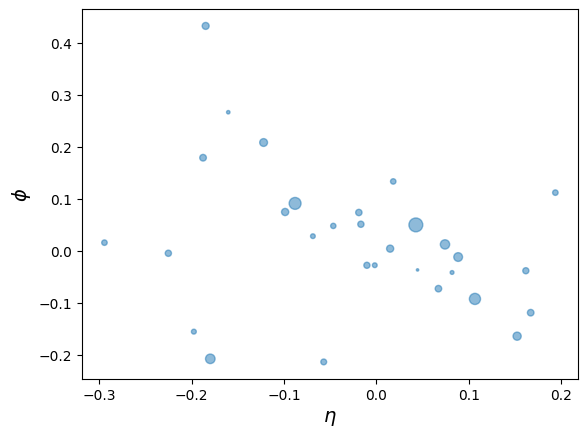

In [14]:
x_sample = single_sample.reshape((n_particles, n_features))
# let's undo the normalization to plot the data
x_sample = x_sample * std_per_feature + mean_per_feature
plt.scatter(*x_sample[:,:2].T, s=1000 * x_sample[:,2], alpha=0.5)
plt.ylabel(r"$\phi$", fontsize=14)
plt.xlabel(r"$\eta$", fontsize=14)


In [15]:
# Now let's vectorize this to draw lots of samples at once super fast
sample_fn = partial(generate_single_sample, noise_prediction_nn, params, t_N=50)

n_samples = 100
sample_key = jax.random.split(key, n_samples)
x_samples = jax.vmap(sample_fn)(sample_key)
x_samples = x_samples.reshape((n_samples, n_particles, n_features))
x_samples = x_samples * std_per_feature + mean_per_feature

Text(0.5, 0.98, 'Generated Jets')

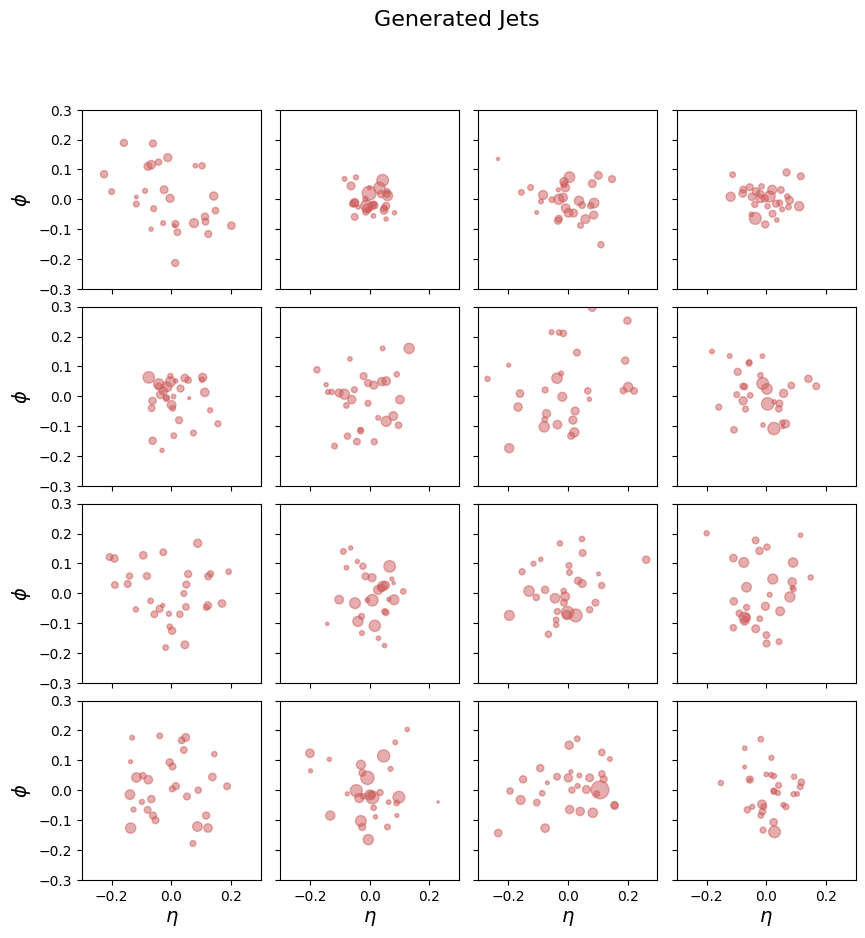

In [16]:
# Let's plot the generated samples

fig = plt.figure(figsize=(10, 10))
gs = GridSpec(4, 4,wspace=0.1, hspace=0.1)

first_ax = None

for i in range(16):
    if i ==0:
        ax = fig.add_subplot(gs[i])
        first_ax = ax
    else:
        ax = fig.add_subplot(gs[i], sharex=first_ax, sharey=first_ax)
        
    
    ax.scatter(*x_samples[i, :, :2].T, s=1000 * (x_samples[i, :, 2]), alpha=0.5, color='indianred')
    ax.set_aspect('equal', adjustable='box')

    
    ax.set_xlim(-0.3, 0.3)
    ax.set_ylim(-0.3, 0.3)
    if i % 4 == 0:
        ax.set_ylabel(r"$\phi$", fontsize=14)
    if i // 4 == 3:
        ax.set_xlabel(r"$\eta$", fontsize=14)
    if i // 4 < 3: # Hide x-tick labels for the first three rows
        plt.setp(ax.get_xticklabels(), visible=False)
    if i % 4 != 0: # Hide y-tick labels for all but the first column
        plt.setp(ax.get_yticklabels(), visible=False)

    # Remove top and right spines
    # Add minor grid lines
    ax.grid(True, which='minor', linestyle=':', linewidth='0.5')


plt.suptitle("Generated Jets", fontsize=16)

let's also compare them at the level of the feature's histograms

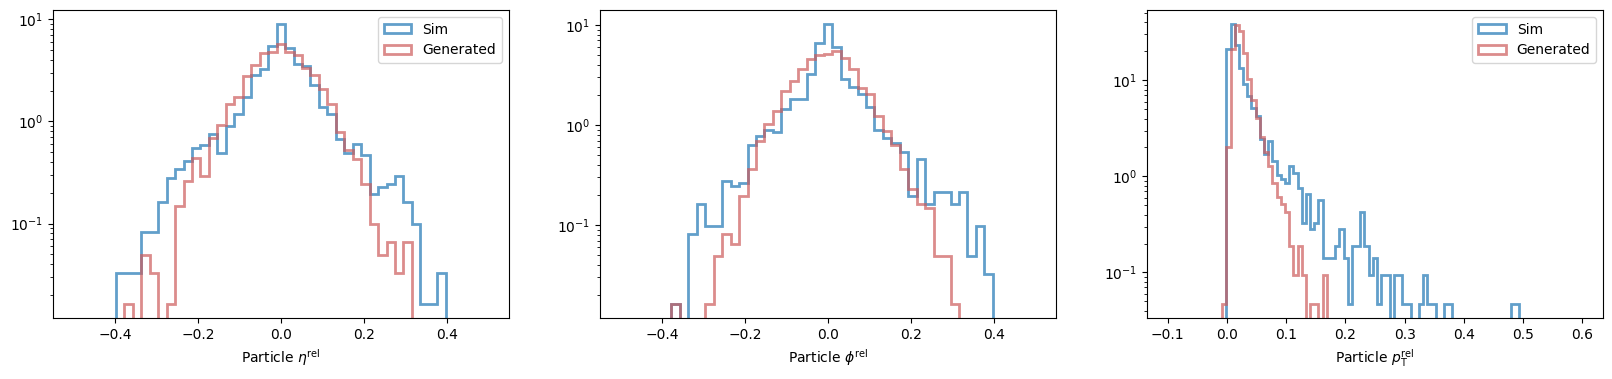

In [17]:
fig, ax = plt.subplots(ncols=3, figsize=(20, 4), sharex=False, sharey=False)

concat_particle_data = np.concatenate(particle_data[:100])
concat_generated_data = np.concatenate(x_samples[:100])

eta_bins= np.linspace(-0.5, 0.5, 50)
ax[0].hist(concat_particle_data[:,0], histtype='step', density=True, bins=eta_bins, lw=2, alpha=0.7, label='Sim',)
ax[0].hist(concat_generated_data[:,0], histtype='step', density=True, bins=eta_bins, lw=2, alpha=0.7, label='Generated', color='indianred')
ax[0].set_xlabel(r"Particle $\eta^\mathrm{rel}$")
ax[0].set_yscale('log')
ax[0].legend()

ax[1].hist(concat_particle_data[:,1], histtype='step', density=True, bins=eta_bins, lw=2, alpha=0.7, label='Sim',)
ax[1].hist(concat_generated_data[:,1], histtype='step', density=True, bins=eta_bins, lw=2, alpha=0.7, label='Generated', color='indianred')
ax[1].set_xlabel(r"Particle $\phi^\mathrm{rel}$")
ax[1].set_yscale('log')
ax[0].legend()


pt_bins= np.linspace(-0.1, 0.6, 100)
ax[2].hist(concat_particle_data[:,2], histtype='step', density=True, bins=pt_bins, lw=2, alpha=0.7, label='Sim',)
ax[2].hist(concat_generated_data[:,2], histtype='step', density=True, bins=pt_bins, lw=2, alpha=0.7, label='Generated', color='indianred')
ax[2].set_xlabel(r"Particle $p_\mathrm{T}^\mathrm{rel}$")
ax[2].legend()

ax[2].set_yscale('log')



🤔 Can we generate samples using the SDE formulation of diffusion models? Remember that

 $\nabla_x \log(q(x_t|x) \approx \frac{x_t - x}{\sigma_t}^2 = - \frac{\epsilon}{\sigma_t}$

Can you implement the SDE sampling function using diffrax? 



## Summary
In this tutorial we have implemented a diffusion model to generate point cloud data. We have also shown how this model can be trained to maximize the likelihood of the data.

Now let's have a look at some research papers using diffusion models to do awesome physics research:
* [Realistic galaxy image simulation via score-based generative models](https://arxiv.org/abs/2111.01713)
* [Posterior Sampling of the Initial Conditions of the Universe from Non-linear Large Scale Structures using Score-Based Generative Models](https://arxiv.org/pdf/2304.03788.pdf)
* [PC-JeDi: Diffusion for Particle Cloud Generation in High Energy Physics](https://arxiv.org/abs/2303.05376)
* [Fast Point Cloud Generation with Diffusion Models in High Energy Physics](https://arxiv.org/abs/2304.01266)
* [Unpaired Downscaling of Fluid Flows with Diffusion Bridges](https://arxiv.org/pdf/2305.01822.pdf)

